In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)
import joblib


csv_path = Path("survey.csv") 
df = pd.read_csv(csv_path)

Timestamp                       0
Age                             0
Gender                          0
Country                         0
state                         515
self_employed                  18
family_history                  0
treatment                       0
work_interfere                264
no_employees                    0
remote_work                     0
tech_company                    0
benefits                        0
care_options                    0
wellness_program                0
seek_help                       0
anonymity                       0
leave                           0
mental_health_consequence       0
phys_health_consequence         0
coworkers                       0
supervisor                      0
mental_health_interview         0
phys_health_interview           0
mental_vs_physical              0
obs_consequence                 0
comments                     1095
dtype: int64

Numeric features: ['Age']
Categorical features: ['Timestamp', 'Gender', 'Country', 'state', 'self_employed', 'family_history', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence', 'comments']
CV Accuracy: 0.829 ± 0.012

Classification Report:
              precision    recall  f1-score   support

          No       0.82      0.78      0.80       124
         Yes       0.80      0.83      0.81       128

    accuracy                           0.81       252
   macro avg       0.81      0.81      0.81       252
weighted avg       0.81      0.81      0.81       252



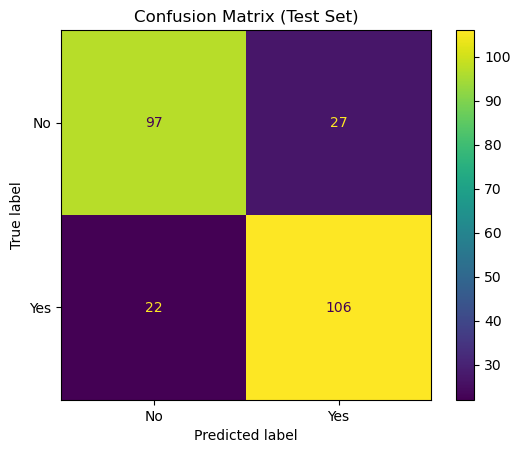

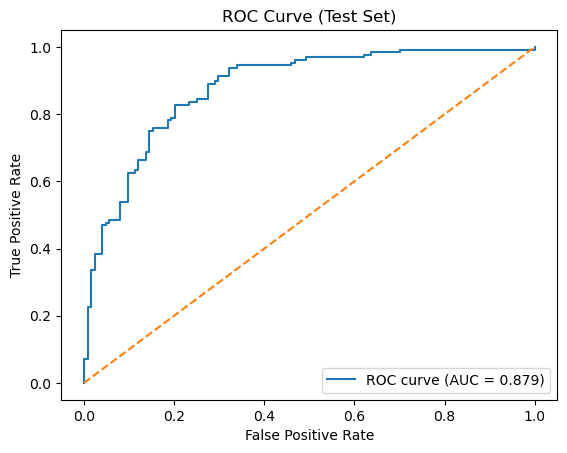


Model saved as 'classification_pipeline.joblib'


In [12]:
target_col = [ "treatment"]

df = df.dropna(axis=1, how="all")
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()

y = df[ "treatment"]
X = df.drop(columns=[ "treatment"])

if pd.api.types.is_numeric_dtype(y) and y.nunique() <= 20:
    y_clean = y.copy()
else:
    y_clean = y.astype("category").cat.remove_unused_categories()

num_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"Numeric features: {num_cols}")
print(f"Categorical features: {cat_cols}")

numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

class_weight = None
if y_clean.nunique() == 2:
    counts = y_clean.value_counts().values
    if counts.min() / counts.max() < 0.6:
        class_weight = "balanced"

log_reg = LogisticRegression(
    max_iter=2000,
    class_weight=class_weight
)

model = Pipeline([
    ("preprocess", preprocess),
    ("clf", log_reg)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y_clean, test_size=0.2, random_state=42,
    stratify=y_clean if y_clean.nunique() <= 20 else None
)

model.fit(X_train, y_train)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) if y_clean.nunique() <= 20 else None
cv_scores = cross_val_score(model, X, y_clean, cv=cv, scoring="accuracy") if cv is not None else None
if cv_scores is not None:
    print(f"CV Accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

y_pred = model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_clean))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_clean))
disp.plot(values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

if y_clean.nunique() == 2 and hasattr(model.named_steps["clf"], "predict_proba"):
    y_score = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=np.unique(y_clean)[1])
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test Set)")
    plt.legend()
    plt.show()

# 13) Save model
joblib.dump(model, "classification_pipeline.joblib")
print("\nModel saved as 'classification_pipeline.joblib'")
